In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import ttach as tta

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision
from torchvision.models import efficientnet_b0
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchsampler import ImbalancedDatasetSampler

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import time
from tqdm import tqdm, trange

import wandb

import coatnet
from efficientnet_pytorch import EfficientNet

import inspect

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 훈련 데이터셋 경로
train_dir = '/opt/ml/input/data/train'
image_dir = '/opt/ml/input/data/train/images'

In [4]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_df = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_class_df = pd.read_csv(os.path.join(train_dir, 'train_class_df.csv'))
train_df.sample(10)
train_class_df.sample(10)

,Unnamed: 0,id,path,class
16976,16976,6392,/opt/ml/input/data/train/images/006392_male_As...,12
17649,17649,6511,/opt/ml/input/data/train/images/006511_male_As...,0
12452,12452,4228,/opt/ml/input/data/train/images/004228_female_...,10
5621,5621,1540,/opt/ml/input/data/train/images/001540_male_As...,2
12769,12769,4288,/opt/ml/input/data/train/images/004288_female_...,17
11685,11685,3848,/opt/ml/input/data/train/images/003848_male_As...,1
13116,13116,4373,/opt/ml/input/data/train/images/004373_male_As...,2
57,57,10,/opt/ml/input/data/train/images/000010_female_...,16
1076,1076,529,/opt/ml/input/data/train/images/000529_female_...,4
7372,7372,1920,/opt/ml/input/data/train/images/001920_female_...,17


In [5]:
# age label 추가
ages = []
for row in train_df['age']:
    if row < 30:
        ages.append(0)
    elif row < 60:
        ages.append(1)
    else:
        ages.append(2)
train_df['age_range'] = ages

print(train_df.head(5))

       id  gender   race  age                    path  age_range
0  000001  female  Asian   45  000001_female_Asian_45          1
1  000002  female  Asian   52  000002_female_Asian_52          1
2  000004    male  Asian   54    000004_male_Asian_54          1
3  000005  female  Asian   58  000005_female_Asian_58          1
4  000006  female  Asian   59  000006_female_Asian_59          1


In [6]:
# Dataset 생성
class MaskDataset(Dataset):
    def __init__(self, df, transform=None):
        self.path = df['path']
        self.label = df['class']
        self.id = df['id']
        self.transform = transform
    
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        image = Image.open(self.path.iloc[idx])
        label = np.array(self.label.iloc[idx])

        if self.transform:
            image = self.transform(image)
            #image = transforms.Resize((256, 256))(image)
            #image = cv2.imread(self.path.iloc[idx])
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #augmented = self.transform(image=image)
            #image = augmented['image']
        return image, torch.tensor(label)
    
    def get_labels(self):
        return self.label

In [7]:
# train, valid 나누기 -> 이 코드에서는 valid만 필요
train, valid = train_test_split(train_class_df,
                                test_size = 0.2,
                                shuffle = True,
                                stratify = train_class_df['class'],
                                random_state = 11)
train.shape, valid.shape
print(train)

       Unnamed: 0    id                                               path  \
17339       17339  6451  /opt/ml/input/data/train/images/006451_female_...   
1894         1894   678  /opt/ml/input/data/train/images/000678_female_...   
10459       10459  3567  /opt/ml/input/data/train/images/003567_female_...   
14302       14302  5129  /opt/ml/input/data/train/images/005129_female_...   
4598         4598  1340  /opt/ml/input/data/train/images/001340_male_As...   
...           ...   ...                                                ...   
937           937   378  /opt/ml/input/data/train/images/000378_female_...   
5502         5502  1522  /opt/ml/input/data/train/images/001522_female_...   
14513       14513  5234  /opt/ml/input/data/train/images/005234_male_As...   
18621       18621  6737  /opt/ml/input/data/train/images/006737_female_...   
5664         5664  1546  /opt/ml/input/data/train/images/001546_male_As...   

       class  
17339      3  
1894       4  
10459     15  
143

## Augmentation

In [8]:
image_paths = pd.read_csv(os.path.join(train_dir, "train_class_df.csv"))['path']

transformation1 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transformation2 = A.Compose([      
    # 수평 뒤집기
    A.HorizontalFlip(p=0.5),
    A.Rotate(15),
    # Contrast Limited Adaptive Histogram Equalization 적용
    A.CLAHE(p=0.5),
    # 무작위로 channel을 섞기
    A.ChannelShuffle(p= 0.05),
    A.ChannelDropout(),
    # normalize
    A.GaussNoise(),
    A.CenterCrop(224, 224),
    ToTensorV2(),
])

transformation3 = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transformation4 = transforms.Compose([
    transforms.CenterCrop((300, 200)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
valid_dataset = MaskDataset(
                valid,
                transform = transformation4
)

In [10]:
batch_size = 32
num_workers = 4

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    #sampler=ImbalancedDatasetSampler(train_dataset),
    drop_last=True
)

## Models

In [14]:
# EfficientNet Model from KKT
class KKT_Effi(nn.Module):
    def __init__(self, num_classes=18):
        super().__init__()
        self.models = torchvision.models.efficientnet_b0(pretrained=True)
        self.models.classifier[1] = nn.Linear(1280, num_classes)



    def forward(self, x):

        return self.models(x)

In [16]:
# ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes = 18, in_channels = 3):
        super(ResNet, self).__init__()
        self.network = torchvision.models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.network(x)
        return x

In [17]:
# CoAtNet model
class MyModel(nn.Module):
    def __init__(self, num_classes=18):
        super().__init__()

        self.model = coatnet.coatnet_0()
        self.fc1 = nn.Linear(1000, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
        
        
    def forward(self, x):
        x = self.model(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Inference

### ensemble

100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


tensor([[[0.0236, 0.0628, 0.0092,  ..., 0.0071, 0.0178, 0.0101],
         [0.1015, 0.1558, 0.1931,  ..., 0.0222, 0.0159, 0.0259],
         [0.0071, 0.3402, 0.5796,  ..., 0.0057, 0.0020, 0.0013],
         ...,
         [0.0057, 0.0344, 0.0071,  ..., 0.0018, 0.0066, 0.0056],
         [0.6819, 0.1052, 0.0151,  ..., 0.0062, 0.0047, 0.0067],
         [0.0043, 0.0992, 0.8327,  ..., 0.0032, 0.0010, 0.0015]]]) tensor([4., 0., 1.,  ..., 4., 0., 2.])


100%|██████████| 118/118 [00:11<00:00, 10.19it/s]


tensor([[[2.3612e-02, 6.2821e-02, 9.1537e-03,  ..., 7.0571e-03,
          1.7813e-02, 1.0057e-02],
         [1.0150e-01, 1.5576e-01, 1.9305e-01,  ..., 2.2215e-02,
          1.5863e-02, 2.5863e-02],
         [7.1256e-03, 3.4020e-01, 5.7956e-01,  ..., 5.7358e-03,
          1.9503e-03, 1.2744e-03],
         ...,
         [5.7352e-03, 3.4354e-02, 7.1103e-03,  ..., 1.8499e-03,
          6.5644e-03, 5.5551e-03],
         [6.8194e-01, 1.0519e-01, 1.5120e-02,  ..., 6.2375e-03,
          4.7257e-03, 6.7118e-03],
         [4.3128e-03, 9.9219e-02, 8.3268e-01,  ..., 3.1577e-03,
          9.7451e-04, 1.4951e-03]],

        [[1.0491e-03, 1.9064e-03, 1.0744e-02,  ..., 1.3052e-03,
          2.5086e-03, 3.8112e-04],
         [8.7946e-01, 1.7661e-02, 4.4420e-03,  ..., 4.6465e-03,
          1.4305e-03, 3.9944e-04],
         [1.4280e-04, 9.8222e-01, 6.9996e-05,  ..., 8.1679e-03,
          3.6283e-03, 9.9072e-04],
         ...,
         [1.7967e-03, 2.4337e-02, 7.5004e-03,  ..., 9.4930e-04,
          5.237

100%|██████████| 118/118 [00:12<00:00,  9.45it/s]


tensor([[[2.3612e-02, 6.2821e-02, 9.1537e-03,  ..., 7.0571e-03,
          1.7813e-02, 1.0057e-02],
         [1.0150e-01, 1.5576e-01, 1.9305e-01,  ..., 2.2215e-02,
          1.5863e-02, 2.5863e-02],
         [7.1256e-03, 3.4020e-01, 5.7956e-01,  ..., 5.7358e-03,
          1.9503e-03, 1.2744e-03],
         ...,
         [5.7352e-03, 3.4354e-02, 7.1103e-03,  ..., 1.8499e-03,
          6.5644e-03, 5.5551e-03],
         [6.8194e-01, 1.0519e-01, 1.5120e-02,  ..., 6.2375e-03,
          4.7257e-03, 6.7118e-03],
         [4.3128e-03, 9.9219e-02, 8.3268e-01,  ..., 3.1577e-03,
          9.7451e-04, 1.4951e-03]],

        [[1.0491e-03, 1.9064e-03, 1.0744e-02,  ..., 1.3052e-03,
          2.5086e-03, 3.8112e-04],
         [8.7946e-01, 1.7661e-02, 4.4420e-03,  ..., 4.6465e-03,
          1.4305e-03, 3.9944e-04],
         [1.4280e-04, 9.8222e-01, 6.9996e-05,  ..., 8.1679e-03,
          3.6283e-03, 9.9072e-04],
         ...,
         [1.7967e-03, 2.4337e-02, 7.5004e-03,  ..., 9.4930e-04,
          5.237

100%|██████████| 118/118 [00:11<00:00, 10.23it/s]


tensor([[[2.3612e-02, 6.2821e-02, 9.1537e-03,  ..., 7.0571e-03,
          1.7813e-02, 1.0057e-02],
         [1.0150e-01, 1.5576e-01, 1.9305e-01,  ..., 2.2215e-02,
          1.5863e-02, 2.5863e-02],
         [7.1256e-03, 3.4020e-01, 5.7956e-01,  ..., 5.7358e-03,
          1.9503e-03, 1.2744e-03],
         ...,
         [5.7352e-03, 3.4354e-02, 7.1103e-03,  ..., 1.8499e-03,
          6.5644e-03, 5.5551e-03],
         [6.8194e-01, 1.0519e-01, 1.5120e-02,  ..., 6.2375e-03,
          4.7257e-03, 6.7118e-03],
         [4.3128e-03, 9.9219e-02, 8.3268e-01,  ..., 3.1577e-03,
          9.7451e-04, 1.4951e-03]],

        [[1.0491e-03, 1.9064e-03, 1.0744e-02,  ..., 1.3052e-03,
          2.5086e-03, 3.8112e-04],
         [8.7946e-01, 1.7661e-02, 4.4420e-03,  ..., 4.6465e-03,
          1.4305e-03, 3.9944e-04],
         [1.4280e-04, 9.8222e-01, 6.9996e-05,  ..., 8.1679e-03,
          3.6283e-03, 9.9072e-04],
         ...,
         [1.7967e-03, 2.4337e-02, 7.5004e-03,  ..., 9.4930e-04,
          5.237

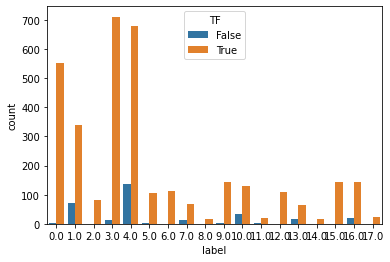

In [45]:
LOAD_PATH = '/opt/ml/result/Best/Team7/'
best_models = os.listdir(LOAD_PATH)
total_outputs = torch.tensor([])
for m in best_models:
    if 'ipynb' in m:
        continue
    if 'three' in m:
        continue

    if 'efficient' in m:
        model = KKT_Effi(num_classes=18).to(device)
    elif 'mask' in m:
        # from KKH
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=18).to(device)
    elif 'Resnet' in m:
        model = ResNet().to(device)
    else:
        model = MyModel().to(device)
    model.load_state_dict(torch.load(LOAD_PATH + m))

    with torch.no_grad():
        model.eval()
        total_labels = torch.tensor([])
        t_outputs = torch.tensor([])
        for val_batch in tqdm(valid_dataloader):
            inputs, labels = val_batch
            outputs = F.softmax(model(inputs.to(device)).cpu(), dim=1)
            t_outputs = torch.cat((t_outputs, outputs), dim=0)
            total_labels = torch.cat((total_labels, labels), dim = 0)       
        total_outputs =  torch.cat((total_outputs, t_outputs.unsqueeze(0)), dim=0)
        
    print(total_outputs, total_labels)    
prediction_array = torch.argmax(total_outputs.mean(axis=0), dim=1)
print(prediction_array)

insert_array = {'TF': total_labels == prediction_array, 'label':total_labels}

validation_eval = pd.DataFrame(None, columns = ["TF", "label"])
validation_eval = validation_eval.append(pd.DataFrame(data=insert_array), ignore_index=True)

accuracy = sklearn.metrics.accuracy_score(prediction_array, total_labels)
f1 = sklearn.metrics.f1_score(prediction_array, total_labels, average="macro")
print('F1: {}, Average accuracy: {}'.format(f1, accuracy))

sns.countplot(
    data = validation_eval,
    x = "label",
    hue = "TF"
)

### tta

Loaded pretrained weights for efficientnet-b0


  0%|          | 0/118 [00:00<?, ?it/s]/tmp/ipykernel_68110/4121189927.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs).cpu()
100%|██████████| 118/118 [02:09<00:00,  1.09s/it]


tensor([[[0.0059, 0.0033, 0.0068,  ..., 0.0045, 0.0108, 0.0030],
         [0.7792, 0.0259, 0.0067,  ..., 0.0048, 0.0067, 0.0043],
         [0.0038, 0.9059, 0.0277,  ..., 0.0043, 0.0033, 0.0049],
         ...,
         [0.0014, 0.0017, 0.0024,  ..., 0.0013, 0.0037, 0.0010],
         [0.8633, 0.0446, 0.0055,  ..., 0.0040, 0.0073, 0.0038],
         [0.0046, 0.0083, 0.9043,  ..., 0.0051, 0.0082, 0.0051]]]) tensor([4., 0., 1.,  ..., 4., 0., 2.])


100%|██████████| 118/118 [01:01<00:00,  1.91it/s]


tensor([[[0.0059, 0.0033, 0.0068,  ..., 0.0045, 0.0108, 0.0030],
         [0.7792, 0.0259, 0.0067,  ..., 0.0048, 0.0067, 0.0043],
         [0.0038, 0.9059, 0.0277,  ..., 0.0043, 0.0033, 0.0049],
         ...,
         [0.0014, 0.0017, 0.0024,  ..., 0.0013, 0.0037, 0.0010],
         [0.8633, 0.0446, 0.0055,  ..., 0.0040, 0.0073, 0.0038],
         [0.0046, 0.0083, 0.9043,  ..., 0.0051, 0.0082, 0.0051]],

        [[0.0117, 0.0052, 0.0074,  ..., 0.0081, 0.0061, 0.0089],
         [0.8611, 0.0200, 0.0046,  ..., 0.0069, 0.0048, 0.0057],
         [0.0022, 0.9342, 0.0073,  ..., 0.0040, 0.0039, 0.0033],
         ...,
         [0.0067, 0.0163, 0.0070,  ..., 0.0089, 0.0052, 0.0079],
         [0.9188, 0.0054, 0.0055,  ..., 0.0036, 0.0055, 0.0070],
         [0.0019, 0.0114, 0.9503,  ..., 0.0027, 0.0025, 0.0028]]]) tensor([4., 0., 1.,  ..., 4., 0., 2.])
tensor([4, 0, 1,  ..., 4, 0, 2])
F1: 0.8071558304968679, Average accuracy: 0.881885593220339


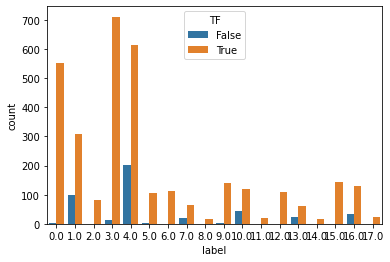

In [26]:
tf = tta.Compose(
[
    tta.HorizontalFlip(),
    tta.Rotate90(angles=[0,15]),
    tta.Multiply(factors=[0.8,0.9,1,1.1]),
])

LOAD_PATH = '/opt/ml/result/Best/Team5/'
best_models = os.listdir(LOAD_PATH)
total_outputs = torch.tensor([])

for m in best_models:
    if 'ipynb' in m:
        continue
    if 'three' in m:
        continue   
    #if 'Team' in m:
    #    continue
    
    if 'EfficientNet' in m:
        model = EfficientNet_MultiLabel().to(device)
        
    elif 'efficient' in m:
        model = KKT_Effi(num_classes=18).to(device)
    elif 'mask' in m:
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=18).to(device)
    elif 'Resnet' in m:
        model = ResNet().to(device)
    else:
        model = MyModel().to(device)
    model.load_state_dict(torch.load(LOAD_PATH + m))
    tta_model = tta.ClassificationTTAWrapper(model,tf)

    with torch.no_grad():
        model.eval()
        total_labels = torch.tensor([])
        t_outputs = torch.tensor([])
        for val_batch in tqdm(valid_dataloader):
            inputs, labels = val_batch
            outputs = tta_model(inputs.to(device))
            outputs = F.softmax(outputs).cpu()
            t_outputs = torch.cat((t_outputs, outputs), dim=0)
            total_labels = torch.cat((total_labels, labels), dim = 0)       
        total_outputs =  torch.cat((total_outputs, t_outputs.unsqueeze(0)), dim=0)
        
    print(total_outputs, total_labels)    
prediction_array = torch.argmax(total_outputs.mean(axis=0), dim=1)
print(prediction_array)

insert_array = {'TF': total_labels == prediction_array, 'label':total_labels}

validation_eval = pd.DataFrame(None, columns = ["TF", "label"])
validation_eval = validation_eval.append(pd.DataFrame(data=insert_array), ignore_index=True)

accuarcy = sklearn.metrics.accuracy_score(prediction_array, total_labels)
f1 = sklearn.metrics.f1_score(prediction_array, total_labels, average="macro")
print('F1: {}, Average accuracy: {}'.format(f1, accuarcy))

#model = ExampleModel()
#model.load_state_dict(torch.load(LOAD_PATH + os.listdir(LOAD_PATH)[0]))
sns.countplot(
    data = validation_eval,
    x = "label",
    hue = "TF"
)

### inference evaluation

#### confusion matrix

In [24]:
class_name = ['WM<30', 'WM<60', 'WM>60', 'WF<30', 'WF<60', 'WF>60', 'IM<30', 'IM<60', 'IM>60', 'IF<30', 'IF<60', 'IF>60', 'NM<30', 'NM<60', 'NM>60', 'NF<30', 'NF<60', 'NF>60']
def plot_confusion_matrix(cm, target_names=class_name, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

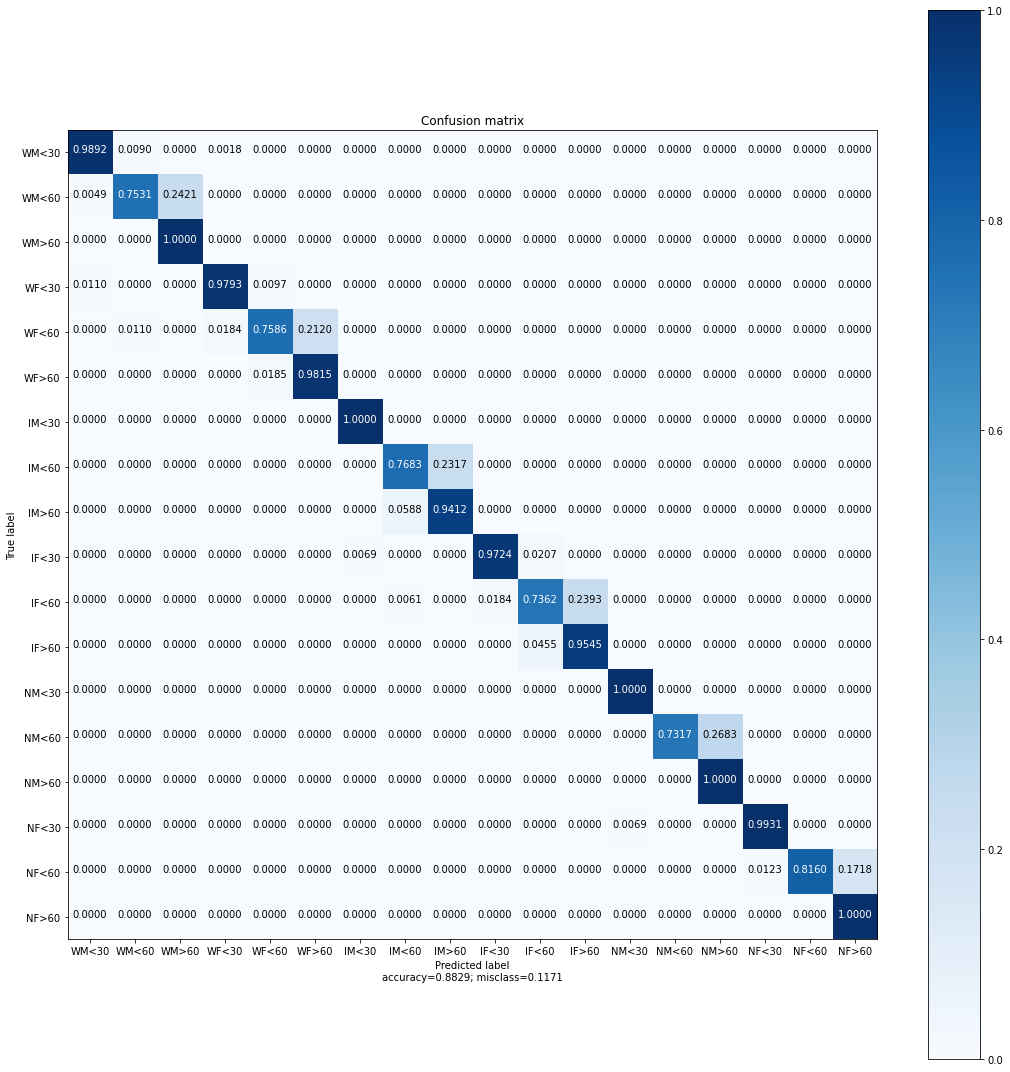

In [25]:
confusion_mat = confusion_matrix(total_labels, prediction_array)
plot_confusion_matrix(confusion_mat)

## Submission

In [28]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
            #image = cv2.imread(self.img_paths[index])
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #augmented = self.transform(image=image)
            #image = augmented['image']
        return image

    def __len__(self):
        return len(self.img_paths)

### ensemble

In [51]:
LOAD_PATH = '/opt/ml/result/Best/Team7/'
test_dir = '/opt/ml/input/data/eval'

submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

test_dataset = TestDataset(image_paths, transform = transformation4)
loader = DataLoader(
    test_dataset,
    shuffle=False,
    num_workers=num_workers
)

best_models = os.listdir(LOAD_PATH)
total_outputs = torch.tensor([])
for m in best_models:
    if 'ipynb' in m:
        continue
    if 'three' in m:
        continue
        
    elif 'efficient' in m:
        model = KKT_Effi(num_classes=18).to(device)
    elif 'mask' in m:
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=18).to(device)
    elif 'Resnet' in m:
        model = ResNet().to(device)
    elif 'three' in m:
        continue
    else:
        model = MyModel().to(device)
    model.load_state_dict(torch.load(LOAD_PATH + m))

    with torch.no_grad():
        model.eval()
        t_outputs = torch.tensor([])
        for val_batch in tqdm(loader):            
            outputs = F.softmax(model(val_batch.to(device, dtype=torch.float32)).cpu(), dim=1)
            t_outputs = torch.cat((t_outputs, outputs), dim=0)   
        total_outputs =  torch.cat((total_outputs, t_outputs.unsqueeze(0)), dim=0)
        
    print(total_outputs)    
prediction_array = torch.argmax(total_outputs.mean(axis=0), dim=1)
print(prediction_array)
submission['ans'] = prediction_array
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print("Submission file generated..!")

100%|██████████| 12600/12600 [03:39<00:00, 57.35it/s]


tensor([[[0.0018, 0.0032, 0.0031,  ..., 0.0030, 0.0051, 0.0022],
         [0.0019, 0.0021, 0.9514,  ..., 0.0021, 0.0026, 0.0015],
         [0.0102, 0.0106, 0.0174,  ..., 0.0049, 0.0085, 0.0833],
         ...,
         [0.0043, 0.0041, 0.0049,  ..., 0.0038, 0.0025, 0.0038],
         [0.1255, 0.2824, 0.0440,  ..., 0.0132, 0.0149, 0.0076],
         [0.0023, 0.0013, 0.0013,  ..., 0.0019, 0.0017, 0.0013]]])


100%|██████████| 12600/12600 [04:08<00:00, 50.65it/s]


tensor([[[0.0018, 0.0032, 0.0031,  ..., 0.0030, 0.0051, 0.0022],
         [0.0019, 0.0021, 0.9514,  ..., 0.0021, 0.0026, 0.0015],
         [0.0102, 0.0106, 0.0174,  ..., 0.0049, 0.0085, 0.0833],
         ...,
         [0.0043, 0.0041, 0.0049,  ..., 0.0038, 0.0025, 0.0038],
         [0.1255, 0.2824, 0.0440,  ..., 0.0132, 0.0149, 0.0076],
         [0.0023, 0.0013, 0.0013,  ..., 0.0019, 0.0017, 0.0013]],

        [[0.0035, 0.0136, 0.0184,  ..., 0.0175, 0.0152, 0.0312],
         [0.0244, 0.4102, 0.3360,  ..., 0.0136, 0.0084, 0.0053],
         [0.0145, 0.0227, 0.0460,  ..., 0.0202, 0.0426, 0.1392],
         ...,
         [0.0174, 0.0188, 0.0352,  ..., 0.1731, 0.0480, 0.0387],
         [0.0339, 0.5603, 0.0683,  ..., 0.0140, 0.0136, 0.0062],
         [0.0114, 0.0303, 0.0318,  ..., 0.0157, 0.0142, 0.0085]]])


100%|██████████| 12600/12600 [02:29<00:00, 84.56it/s] 


tensor([[[1.8466e-03, 3.2066e-03, 3.1246e-03,  ..., 2.9559e-03,
          5.1358e-03, 2.1898e-03],
         [1.9368e-03, 2.1377e-03, 9.5143e-01,  ..., 2.1427e-03,
          2.5556e-03, 1.4822e-03],
         [1.0178e-02, 1.0635e-02, 1.7370e-02,  ..., 4.9179e-03,
          8.5292e-03, 8.3256e-02],
         ...,
         [4.2746e-03, 4.0539e-03, 4.9432e-03,  ..., 3.8013e-03,
          2.4913e-03, 3.8460e-03],
         [1.2545e-01, 2.8241e-01, 4.4017e-02,  ..., 1.3198e-02,
          1.4853e-02, 7.5744e-03],
         [2.3306e-03, 1.3460e-03, 1.2530e-03,  ..., 1.9334e-03,
          1.7035e-03, 1.3387e-03]],

        [[3.4531e-03, 1.3579e-02, 1.8435e-02,  ..., 1.7488e-02,
          1.5155e-02, 3.1185e-02],
         [2.4402e-02, 4.1017e-01, 3.3600e-01,  ..., 1.3555e-02,
          8.4229e-03, 5.2816e-03],
         [1.4511e-02, 2.2724e-02, 4.5953e-02,  ..., 2.0182e-02,
          4.2594e-02, 1.3919e-01],
         ...,
         [1.7384e-02, 1.8800e-02, 3.5235e-02,  ..., 1.7308e-01,
          4.797

100%|██████████| 12600/12600 [05:05<00:00, 41.28it/s]


tensor([[[1.8466e-03, 3.2066e-03, 3.1246e-03,  ..., 2.9559e-03,
          5.1358e-03, 2.1898e-03],
         [1.9368e-03, 2.1377e-03, 9.5143e-01,  ..., 2.1427e-03,
          2.5556e-03, 1.4822e-03],
         [1.0178e-02, 1.0635e-02, 1.7370e-02,  ..., 4.9179e-03,
          8.5292e-03, 8.3256e-02],
         ...,
         [4.2746e-03, 4.0539e-03, 4.9432e-03,  ..., 3.8013e-03,
          2.4913e-03, 3.8460e-03],
         [1.2545e-01, 2.8241e-01, 4.4017e-02,  ..., 1.3198e-02,
          1.4853e-02, 7.5744e-03],
         [2.3306e-03, 1.3460e-03, 1.2530e-03,  ..., 1.9334e-03,
          1.7035e-03, 1.3387e-03]],

        [[3.4531e-03, 1.3579e-02, 1.8435e-02,  ..., 1.7488e-02,
          1.5155e-02, 3.1185e-02],
         [2.4402e-02, 4.1017e-01, 3.3600e-01,  ..., 1.3555e-02,
          8.4229e-03, 5.2816e-03],
         [1.4511e-02, 2.2724e-02, 4.5953e-02,  ..., 2.0182e-02,
          4.2594e-02, 1.3919e-01],
         ...,
         [1.7384e-02, 1.8800e-02, 3.5235e-02,  ..., 1.7308e-01,
          4.797

100%|██████████| 12600/12600 [02:05<00:00, 100.29it/s]


tensor([[[1.8466e-03, 3.2066e-03, 3.1246e-03,  ..., 2.9559e-03,
          5.1358e-03, 2.1898e-03],
         [1.9368e-03, 2.1377e-03, 9.5143e-01,  ..., 2.1427e-03,
          2.5556e-03, 1.4822e-03],
         [1.0178e-02, 1.0635e-02, 1.7370e-02,  ..., 4.9179e-03,
          8.5292e-03, 8.3256e-02],
         ...,
         [4.2746e-03, 4.0539e-03, 4.9432e-03,  ..., 3.8013e-03,
          2.4913e-03, 3.8460e-03],
         [1.2545e-01, 2.8241e-01, 4.4017e-02,  ..., 1.3198e-02,
          1.4853e-02, 7.5744e-03],
         [2.3306e-03, 1.3460e-03, 1.2530e-03,  ..., 1.9334e-03,
          1.7035e-03, 1.3387e-03]],

        [[3.4531e-03, 1.3579e-02, 1.8435e-02,  ..., 1.7488e-02,
          1.5155e-02, 3.1185e-02],
         [2.4402e-02, 4.1017e-01, 3.3600e-01,  ..., 1.3555e-02,
          8.4229e-03, 5.2816e-03],
         [1.4511e-02, 2.2724e-02, 4.5953e-02,  ..., 2.0182e-02,
          4.2594e-02, 1.3919e-01],
         ...,
         [1.7384e-02, 1.8800e-02, 3.5235e-02,  ..., 1.7308e-01,
          4.797

### tta

In [57]:
import ttach as tta

tf = tta.Compose(
[
    tta.HorizontalFlip(),
    tta.Rotate90(angles=[0,15]),
    tta.Multiply(factors=[0.8,0.9,1,1.1]),
])

LOAD_PATH = '/opt/ml/result/Best/Team7/'
test_dir = '/opt/ml/input/data/eval'

submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

test_dataset = TestDataset(image_paths, transform = transformation4)
loader = DataLoader(
    test_dataset,
    shuffle=False,
    num_workers=num_workers
)

best_models = os.listdir(LOAD_PATH)
total_outputs = torch.tensor([])
for m in best_models:
    if 'ipynb' in m:
        continue
    if 'three' in m:
        continue
        
    elif 'efficient' in m:
        model = KKT_Effi(num_classes=18).to(device)
    elif 'mask' in m:
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=18).to(device)
    elif 'Resnet' in m:
        model = ResNet().to(device)
    elif 'three' in m:
        continue
    else:
        model = MyModel().to(device)
    model.load_state_dict(torch.load(LOAD_PATH + m))
    tta_model = tta.ClassificationTTAWrapper(model,tf)

    with torch.no_grad():
        model.eval()
        t_outputs = torch.tensor([])
        for val_batch in tqdm(loader):
            outputs = F.softmax(tta_model(val_batch.to(device, dtype=torch.float32)).cpu(), dim=1)
            t_outputs = torch.cat((t_outputs, outputs), dim=0)   
        total_outputs =  torch.cat((total_outputs, t_outputs.unsqueeze(0)), dim=0)
        
    print(total_outputs, total_labels)    
prediction_array = torch.argmax(total_outputs.mean(axis=0), dim=1)
print(prediction_array)
submission['ans'] = prediction_array
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print("Submission file generated..!")

100%|██████████| 12600/12600 [37:04<00:00,  5.66it/s]


tensor([[[0.0026, 0.0131, 0.0087,  ..., 0.0121, 0.0166, 0.0138],
         [0.0343, 0.3637, 0.2850,  ..., 0.0167, 0.0118, 0.0084],
         [0.0174, 0.0282, 0.0400,  ..., 0.0204, 0.0686, 0.1531],
         ...,
         [0.0203, 0.0245, 0.0416,  ..., 0.1611, 0.0503, 0.0392],
         [0.0224, 0.6892, 0.0561,  ..., 0.0097, 0.0094, 0.0034],
         [0.0113, 0.0233, 0.0403,  ..., 0.0149, 0.0121, 0.0109]]]) tensor([4., 0., 1.,  ..., 4., 0., 2.])


  0%|          | 0/12600 [00:00<?, ?it/s]

tensor([[[2.6327e-03, 1.3065e-02, 8.6945e-03,  ..., 1.2138e-02,
          1.6590e-02, 1.3815e-02],
         [3.4264e-02, 3.6370e-01, 2.8497e-01,  ..., 1.6733e-02,
          1.1781e-02, 8.3753e-03],
         [1.7439e-02, 2.8225e-02, 3.9994e-02,  ..., 2.0390e-02,
          6.8561e-02, 1.5314e-01],
         ...,
         [2.0288e-02, 2.4516e-02, 4.1560e-02,  ..., 1.6108e-01,
          5.0337e-02, 3.9171e-02],
         [2.2355e-02, 6.8916e-01, 5.6104e-02,  ..., 9.7398e-03,
          9.4342e-03, 3.4021e-03],
         [1.1315e-02, 2.3257e-02, 4.0328e-02,  ..., 1.4941e-02,
          1.2130e-02, 1.0936e-02]],

        [[2.4611e-04, 2.2259e-03, 4.0374e-03,  ..., 1.1243e-02,
          3.1737e-02, 4.0405e-04],
         [2.8814e-04, 8.6655e-01, 1.5966e-02,  ..., 3.0559e-03,
          1.5199e-03, 8.6711e-04],
         [2.0236e-03, 4.4097e-03, 7.0924e-03,  ..., 9.5996e-03,
          8.3819e-02, 4.1251e-02],
         ...,
         [4.8723e-03, 3.0930e-03, 1.9718e-03,  ..., 1.6114e-03,
          2.522

100%|██████████| 12600/12600 [42:59<00:00,  4.88it/s] 


tensor([[[2.6327e-03, 1.3065e-02, 8.6945e-03,  ..., 1.2138e-02,
          1.6590e-02, 1.3815e-02],
         [3.4264e-02, 3.6370e-01, 2.8497e-01,  ..., 1.6733e-02,
          1.1781e-02, 8.3753e-03],
         [1.7439e-02, 2.8225e-02, 3.9994e-02,  ..., 2.0390e-02,
          6.8561e-02, 1.5314e-01],
         ...,
         [2.0288e-02, 2.4516e-02, 4.1560e-02,  ..., 1.6108e-01,
          5.0337e-02, 3.9171e-02],
         [2.2355e-02, 6.8916e-01, 5.6104e-02,  ..., 9.7398e-03,
          9.4342e-03, 3.4021e-03],
         [1.1315e-02, 2.3257e-02, 4.0328e-02,  ..., 1.4941e-02,
          1.2130e-02, 1.0936e-02]],

        [[2.4611e-04, 2.2259e-03, 4.0374e-03,  ..., 1.1243e-02,
          3.1737e-02, 4.0405e-04],
         [2.8814e-04, 8.6655e-01, 1.5966e-02,  ..., 3.0559e-03,
          1.5199e-03, 8.6711e-04],
         [2.0236e-03, 4.4097e-03, 7.0924e-03,  ..., 9.5996e-03,
          8.3819e-02, 4.1251e-02],
         ...,
         [4.8723e-03, 3.0930e-03, 1.9718e-03,  ..., 1.6114e-03,
          2.522

100%|██████████| 12600/12600 [08:48<00:00, 23.85it/s]

tensor([[[2.6327e-03, 1.3065e-02, 8.6945e-03,  ..., 1.2138e-02,
          1.6590e-02, 1.3815e-02],
         [3.4264e-02, 3.6370e-01, 2.8497e-01,  ..., 1.6733e-02,
          1.1781e-02, 8.3753e-03],
         [1.7439e-02, 2.8225e-02, 3.9994e-02,  ..., 2.0390e-02,
          6.8561e-02, 1.5314e-01],
         ...,
         [2.0288e-02, 2.4516e-02, 4.1560e-02,  ..., 1.6108e-01,
          5.0337e-02, 3.9171e-02],
         [2.2355e-02, 6.8916e-01, 5.6104e-02,  ..., 9.7398e-03,
          9.4342e-03, 3.4021e-03],
         [1.1315e-02, 2.3257e-02, 4.0328e-02,  ..., 1.4941e-02,
          1.2130e-02, 1.0936e-02]],

        [[2.4611e-04, 2.2259e-03, 4.0374e-03,  ..., 1.1243e-02,
          3.1737e-02, 4.0405e-04],
         [2.8814e-04, 8.6655e-01, 1.5966e-02,  ..., 3.0559e-03,
          1.5199e-03, 8.6711e-04],
         [2.0236e-03, 4.4097e-03, 7.0924e-03,  ..., 9.5996e-03,
          8.3819e-02, 4.1251e-02],
         ...,
         [4.8723e-03, 3.0930e-03, 1.9718e-03,  ..., 1.6114e-03,
          2.522

### submission 개형

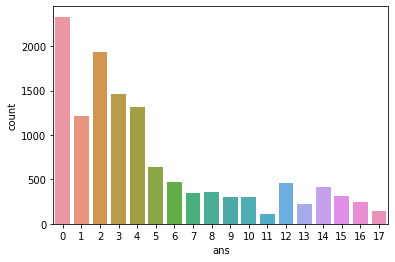

In [50]:
submission = pd.read_csv(os.path.join(test_dir, "submission_team7.csv"))
sns.countplot(
    data = submission,
    x = "ans",
)

### 지금까지의 best submission과 비교

In [ ]:
# submission: KKT+KKH, TTA

test_dir = '/opt/ml/input/data/eval'

submission_best = pd.read_csv(os.path.join(test_dir, "submission_team7.csv"))
submission_compare = pd.read_csv(os.path.join(test_dir, "submission_team8.csv"))

submission_best_ans = submission_best['ans'].tolist()
submission_compare_ans = submission_compare['ans'].tolist()

f1 = sklearn.metrics.f1_score(submission_compare_ans, submission_best_ans, average="macro")
print('F1: {}'.format(f1))

compare_matrix = confusion_matrix(submission_best_ans, submission_compare_ans)
plot_confusion_matrix(compare_matrix)
#plt.ylabel('best submission')
#plt.xlabel('compare submission\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))